# What constitutes Software? An Empirical, Descriptive Study of Artifacts

This notebook contains all code that was used to create the figures, tables and numbers in Section 4 of the paper _"What constitutes Software? An Empirical, Descriptive Study of Artifacts"_.

Note, all code cells should be executed in consecutive order, i.e., top-down.

This notebook is structured in four sections, where the latter three reproduce the paper's figures, tables, and numbers that are inlined in text: 

1. [Setup](#Setup)
2. [Figures](#Figures)
  - [Figure 2](#Figure-2:-Distribution-of-relative-frequencies-per-high-level-artifact-category.)
  - [Figure 3](#Figure-3:-Distribution-of-relative-frequencies-per-concrete-artifact-category.)
  - [Figure 4](#Figure-4:-Cumulative-relative-frequencies-of-repositories-with-artifacts-of-x-different-concrete-categories-(blue).-In-orange-the-amount-of-those-containing-documentation.)
  - [Figure 5](#Figure-5:-Median-(y-axis)-of-relative-frequencies-of-code,-data,-and-documentation-respectively-in-repositories-with-at-least-six-artifacts-and-per-category-distribution-as-given-in-legend.)
3. [Tables](#Tables)
  - [Table 3](#Table-3---Overview-of-amount-of-occurrences-of-the-high-level-category-combinations-in-the-dataset.)
  - [Table 4](#Table-4---Occurrence-frequencies-of-the-five-most-common-concrete-category-combinations-grouped-by-high-level-category.)
4. [Inline Text](#Inline-Text)
  - [RQ1: To which degree is software more than code?](#RQ1:-To-which-degree-is-software-more-than-code?)
  - [RQ2: Is documentation an integral constituent of software?](#RQ2:-Is-documentation-an-integral-constituent-of-software?)
  - [RQ3: Does software without data artifacts exist?](#RQ3:-Does-software-without-data-artifacts-exist?)
  - [RQ4: Does software without code exist?](#RQ4:-Does-software-without-code-exist?)
  - [RQ5: Does a characteristic distribution of frequencies of artifacts
categories exist?](#RQ5:-Does-a-characteristic-distribution-of-frequencies-of-artifacts-categories-exist?)
  - [RQ6: Does the ratio between frequencies of artifacts categories depend on the size of software?](#RQ6:-Does-the-ratio-between-frequencies-of-artifacts-categories-depend-on-the-size-of-software?)

Section 4. [Inline Text](#Inline-Text), has a text cell with the corresponding text from the paper on top of each code cell.

## Setup

### Imports and configuration of this notebook.

Run this cell before any of the others.

In [2]:
%matplotlib notebook

import os
import shutil
import requests
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
# To properly get rid of the warnings, assure that the local scipy is build against the local numpy
# https://stackoverflow.com/questions/40845304/runtimewarning-numpy-dtype-size-changed-may-indicate-binary-incompatibility
import numpy as np
import pandas as pd
from pprint import pprint
from collections import Counter
from scipy.stats import anderson
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

### Getting the Dataset

The dataset is stored as a release on Github and will be moved to Zenodo on publication of this paper.

The dataset is stored as a BZ2 compressed CSV file (186MB). It does not have to be decompressed manually. However, as it would be ca. 5.3GB in size after decompression, the machine running this notebook should have around 8GB of RAM.

In [3]:
dataset_url = "https://github.com/HelgeCPH/msr2020_what_constitutes_software/"\
              "releases/download/v1.0-data/all_repo_files_categorized.csv.bz2"
local_filename = os.path.basename(dataset_url)

if not os.path.isfile(local_filename):
    response = requests.get(dataset_url, stream=True)
    with open(local_filename, 'wb') as fp:
        shutil.copyfileobj(response.raw, fp)
    del response

In [4]:
complete_csv = local_filename
DF = pd.read_csv(complete_csv, compression="infer", lineterminator="\n",
                 na_filter=False, low_memory=False)

### Data preparation

Make a proper description string for the _other_ category.

In [5]:
mask = (DF['easy_kind'] == '')
DF['easy_kind'][mask] = 'other'
DF['major'][mask] = 'other'

In [6]:
def create_feature_df(category='easy_kind'):
    """Creates a dataframe holding the absolute amount of artifacts 
    and the frequencies of each concrete category (category='easy_kind')
    or of each high-level category (category='major')
    """
    s = DF.groupby(['owner']).path.count()
    df = s.reset_index(name='size')
    s = DF.groupby(['owner'])[category].aggregate(lambda x: tuple(x))

    if category == 'easy_kind':
        cols = [
            # code
            'source code', 'spec. source code', 'binary code', 
            'build', 'script', 'infrastructure',
            # data
            'image', 'video', 'music', 'configuration', 'database', 
            'font', 'archive', 'markup', 'document', 'app data',
            # documentation
            'prose', 'legalese',
            # other
            'other'
        ]
    elif category == 'major':
        cols = ['code', 'data', 'documentation', 'other']

    kind_freqs = []
    for owner, kinds in s.items():
        freqs = dict(Counter(kinds))
        row = []
        for f in cols:
            row.append(freqs.get(f, 0))
        kind_freqs.append(row)
    df_features = pd.DataFrame(kind_freqs, columns=cols)

    df_features = df.join(df_features)
    return df_features

Create a dataframe, which holds the absolute amount of artifacts and the frequencies of each concrete category.

In [7]:
df_easy_kind = create_feature_df('easy_kind')

Create a dataframe, which holds the absolute amount of artifacts and the frequencies of each high-level category.

In [8]:
df_major = create_feature_df(category='major')

In [9]:
def normalize_features(df, category='easy_kind'):
    """Given a dataframe as produced by `create_feature_df` create a 
    dataframe with relative frequencies instead of absolute frequencies."""
    if category == 'easy_kind': 
        cols = ['source code', 'spec. source code', 'binary code',
                'build', 'script', 'infrastructure', 'image', 'video', 
                'music', 'configuration', 'database', 'font', 
                'archive', 'markup', 'document', 'app data', 'prose', 
                'legalese', 'other']
    elif category == 'major':
        cols = ['code', 'data', 'documentation', 'other']

    df_normalized = (df[cols].T / df['size']).T
    # The transpose has to be done for correct division of column values, 
    # see https://stackoverflow.com/a/15916686
    return df[['owner', 'size']].join(df_normalized)

Create two more dataframes, which hold the relative amount of artifacts and the frequencies of each concrete category or high-level category respectively.

In [10]:
df_easy_kind_norm = normalize_features(df_easy_kind, category='easy_kind')
df_major_norm = normalize_features(df_major, category='major')

In [11]:
df_major_norm.describe()

,size,code,data,documentation,other
count,23715.000000,23715.000000,23715.000000,23715.000000,23715.000000
mean,583.602867,0.632704,0.253837,0.112816,0.000643
std,2803.132638,0.235716,0.223901,0.134621,0.010523
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,0.469388,0.069996,0.029126,0.000000
50%,73.000000,0.666667,0.189189,0.066667,0.000000
75%,254.000000,0.827586,0.400000,0.142857,0.000000
max,90976.000000,1.000000,1.000000,1.000000,0.666667


In [12]:
def add_combination_col(df, category='easy_kind'):
    def mk_string(lst):
        return ','.join(sorted(set(lst)))
    
    s = DF.groupby(['owner'])[category].aggregate(mk_string)
    mini_df = s.reset_index(name="cat_combo")
    return df.merge(mini_df, left_on='owner', right_on='owner')

Create two dataframes that are like `df_major_norm` and `df_easy_kind_norm` respectively but with an extra column holding the combinations of high-level or concrete categories occuring in the respective repositories.

In [13]:
df_major_norm_cat = add_combination_col(df_major_norm, category='major')
df_easy_kind_norm_cat = add_combination_col(df_easy_kind_norm, category='easy_kind')

------------------------------------------------------------

### Number of artifacts in the entire dataset

An artifact is addressable by its path 

In [14]:
no_repos = len(DF.owner.unique())
total_no_artifacts = DF.path.size
print(f"There are {total_no_artifacts} artifacts in the entire dataset.")
print(f"There are {no_repos} repositories in the entire dataset.")

#total_no_unique_kinds = DF.kind.unique().size
#print(f"There are {total_no_unique_kinds} unique kinds in the dataset.")

There are 13840142 artifacts in the entire dataset.
There are 23715 repositories in the entire dataset.


-----------------------------------------------------------------

## Tables

### Table 3 - Overview of amount of occurrences of the high-level category combinations in the dataset.

In [15]:
cat_com_freqs = Counter(df_major_norm_cat.cat_combo)

cat_combination_strs = []
occurence_freqs = []
relative_occurence_freqs = []

for name, v in dict(cat_com_freqs).items():
    cat_combination_strs.append(', '.join(name.split(',')))
    occurence_freqs.append(v)
    
    rel_v = v / no_repos
    relative_occurence_freqs.append(round(rel_v * 100, 3))

data={'Category combination': cat_combination_strs, 
      'Occurrence Frequency': occurence_freqs, 
      'Occurrence in %': relative_occurence_freqs}
table_3_df = pd.DataFrame(data=data)
table_3_df

,Category combination,Occurrence Frequency,Occurrence in %
0,"code, data, documentation",20650,87.076
1,"code, data, documentation, other",1068,4.503
2,"code, documentation",1406,5.929
3,"code, data",286,1.206
4,code,234,0.987
5,documentation,23,0.097
6,data,3,0.013
7,"data, documentation",35,0.148
8,"code, documentation, other",5,0.021
9,"code, data, other",3,0.013


### Table 4 - Occurrence frequencies of the five most common concrete category combinations grouped by high-level category.

In [16]:
Counter(df_easy_kind_norm_cat.cat_combo).most_common(5)

[('app data,archive,build,configuration,image,legalese,markup,prose,script,source code,spec. source code',
  930),
 ('app data,build,configuration,image,legalese,markup,prose,script,source code,spec. source code',
  546),
 ('prose,source code', 445),
 ('markup,prose,source code', 351),
 ('app data,configuration,image,legalese,markup,prose,source code,spec. source code',
  342)]

In [17]:
cat_com_freqs = Counter(df_easy_kind_norm_cat.cat_combo).most_common(5)

category_combination = []
no_concrete_combination = []
abs_freq = []
ref_feq = []

for v, f in cat_com_freqs:
    concrete_categories = v.split(',')
    category_combination.append(', '.join(concrete_categories))
    no_concrete_combination.append(len(concrete_categories))
    abs_freq.append(f)
    ref_feq.append(round((f / no_repos) * 100, 2))

data = {'Category combination': category_combination,
        '# Concr. Categ.': no_concrete_combination,
        'Abs. freq.': abs_freq,
        'Rel. freq.': ref_feq}

with pd.option_context('display.max_colwidth', 150):
    display(pd.DataFrame(data=data))

,Category combination,# Concr. Categ.,Abs. freq.,Rel. freq.
0,"app data, archive, build, configuration, image, legalese, markup, prose, script, source code, spec. source code",11,930,3.92
1,"app data, build, configuration, image, legalese, markup, prose, script, source code, spec. source code",10,546,2.30
2,"prose, source code",2,445,1.88
3,"markup, prose, source code",3,351,1.48
4,"app data, configuration, image, legalese, markup, prose, source code, spec. source code",8,342,1.44


-----------------------------------------------------------------

## Figures

### Figure 2: Distribution of relative frequencies per high-level artifact category.

<IPython.core.display.Javascript object>


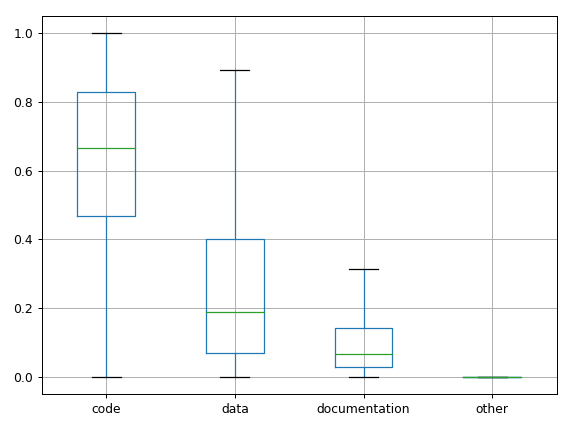

In [18]:
%matplotlib notebook


categories = ['code', 'data', 'documentation', 'other']
df_major_norm_cat.boxplot(column=categories, showfliers=False)
plt.tight_layout()
plt.savefig("images/major_cat_dist.png")

### Figure 3: Distribution of relative frequencies per concrete artifact category.

<IPython.core.display.Javascript object>


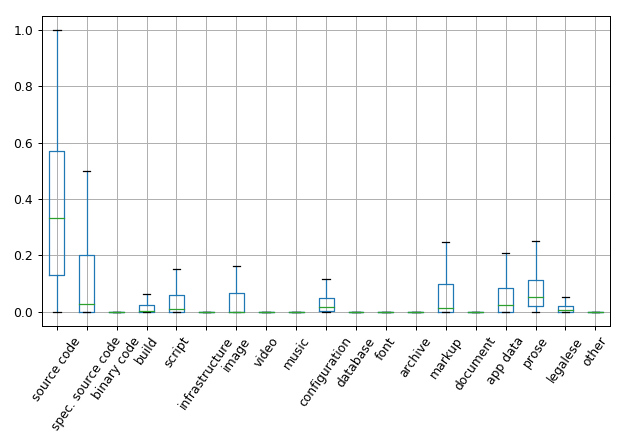

In [19]:
%matplotlib notebook


categories = ['source code', 'spec. source code', 'binary code',
              'build', 'script', 'infrastructure', 'image', 'video', 'music',
              'configuration', 'database', 'font', 'archive', 'markup', 
              'document', 'app data', 'prose', 'legalese', 'other']
df_easy_kind_norm_cat.boxplot(column=categories, rot=55, showfliers=False, 
                              figsize=(7, 5))
plt.tight_layout()
plt.savefig('images/cat_dist_concrete.png')

### Figure 4: Cumulative relative frequencies of repositories with artifacts of x different concrete categories (blue). In orange the amount of those containing documentation.

<IPython.core.display.Javascript object>


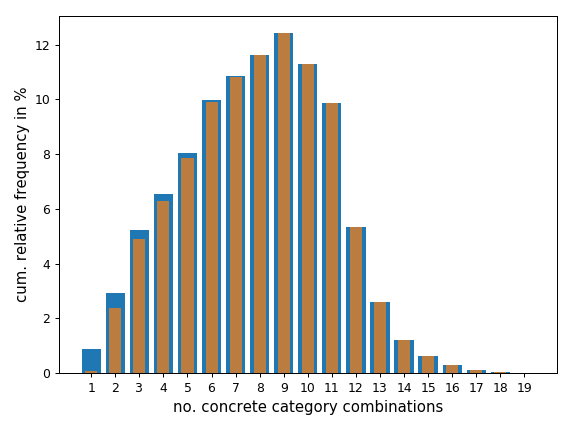

/usr/local/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [20]:
%matplotlib notebook


len_s = df_easy_kind_norm_cat.cat_combo.str.split(',').apply(len)
x_s = list(range(1, 20))
y_s = []
y2_s = []
for x in x_s:
    y_s.append(df_easy_kind_norm_cat[len_s == x].shape[0] / 
               df_easy_kind_norm_cat.shape[0] * 100)
    mask = ((len_s == x) & 
            ((df_easy_kind_norm_cat.cat_combo.str.contains('prose')) | 
             (df_easy_kind_norm_cat.cat_combo.str.contains('legalese'))))
    no_docu_contained = df_easy_kind_norm_cat[mask].shape[0]
    doc_share = no_docu_contained / no_repos * 100
    y2_s.append(doc_share)

plt.bar(x_s, y_s)
plt.bar([x-0.25 for x in x_s], y2_s, width=0.5, align='edge', alpha=0.7)
plt.axes().set_xticks(x_s)

plt.xlabel('no. concrete category combinations', fontsize=12)
plt.ylabel('cum. relative frequency in %', fontsize=12)
plt.tight_layout()
plt.savefig('images/concr_cat_comb_freqs.png')

### Figure 5: Median (y-axis) of relative frequencies of code, data, and documentation respectively in repositories with at least six artifacts and per category distribution as given in legend.

<IPython.core.display.Javascript object>


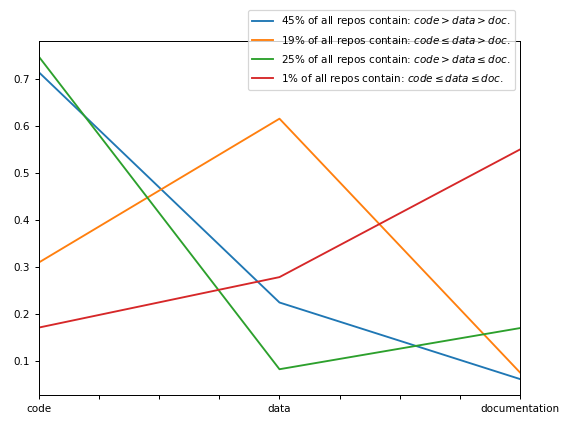

In [21]:
%matplotlib notebook


mask = ((df_major_norm_cat['size'] >= 6) & 
        ((df_major_norm_cat.cat_combo == 'code,data,documentation') | 
         (df_major_norm_cat.cat_combo == 'code,data,documentation,other')))
df_rq5 = df_major_norm_cat[mask].copy()

df_rq5['r_code_data'] = (df_rq5.code / df_rq5.data)
df_rq5['r_data_doc'] = (df_rq5.data / df_rq5.documentation)

mask = (df_rq5.r_code_data > 1) & (df_rq5.r_data_doc > 1)
share_gg = round(df_rq5[mask].shape[0] / no_repos * 100)
xs_gg = df_rq5[mask].describe()[['code', 'data', 'documentation']].loc['mean'].values
mask = (df_rq5.r_code_data <= 1) & (df_rq5.r_data_doc > 1)
share_lg = round(df_rq5[mask].shape[0] / no_repos * 100)
xs_lg = df_rq5[mask].describe()[['code', 'data', 'documentation']].loc['mean'].values
mask = (df_rq5.r_code_data > 1) & (df_rq5.r_data_doc <= 1)
share_gl = round(df_rq5[mask].shape[0] / no_repos * 100)
xs_gl = df_rq5[mask].describe()[['code', 'data', 'documentation']].loc['mean'].values
mask = (df_rq5.r_code_data <= 1) & (df_rq5.r_data_doc <= 1)
share_ll = round(df_rq5[mask].shape[0] / no_repos * 100)
xs_ll = df_rq5[mask].describe()[['code', 'data', 'documentation']].loc['mean'].values

data_dict = {
    f'{share_gg}% of all repos contain: $code > data > doc.$': xs_gg, 
    f'{share_lg}% of all repos contain: $code \leq data > doc.$': xs_lg, 
    f'{share_gl}% of all repos contain: $code > data \leq doc.$': xs_gl, 
    f'{share_ll}% of all repos contain: $code \leq data \leq doc.$': xs_ll, 
}
df_dist = pd.DataFrame(data_dict)
df_dist.set_axis(['code', 'data', 'documentation'], axis=0, inplace=True)
ax = df_dist.plot(fontsize='small')
ax.legend(bbox_to_anchor=(1, 1.1), fontsize='small')
plt.tight_layout()
plt.savefig('images/code_dat_doc_distribution.png')

-----------------------------------------------------------------
## Inline Text

  > The over 13M artifacts are not distributed equally over the the analyzed repositories. There are at minimum one artifact and at maximum 90\,976 artifacts in each repository. On average there are ca. 583, median 73 (q1: 25, q3: 254, std. ca. 2\,803).

In [22]:
artifact_series = DF.groupby(['owner']).path.count()
artifact_series.describe().round(2)

count    23715.00
mean       583.60
std       2803.13
min          1.00
25%         25.00
50%         73.00
75%        254.00
max      90976.00
Name: path, dtype: float64

### RQ1: To which degree is software more than code?


  > ... and that usually $\tfrac{2}{3}$ ($q_{2}$: 67\%, $\mu$: 63\%, $\sigma$: 0.24) of a repository are code.

In [23]:
df_major_norm_cat.describe()

,size,code,data,documentation,other
count,23715.000000,23715.000000,23715.000000,23715.000000,23715.000000
mean,583.602867,0.632704,0.253837,0.112816,0.000643
std,2803.132638,0.235716,0.223901,0.134621,0.010523
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,0.469388,0.069996,0.029126,0.000000
50%,73.000000,0.666667,0.189189,0.066667,0.000000
75%,254.000000,0.827586,0.400000,0.142857,0.000000
max,90976.000000,1.000000,1.000000,1.000000,0.666667


  > 234 code-only repositories, contain most often (71%) only source 779 code, 13% of them contain also binary code, and rarely (3%) build code.

In [24]:
mask = (df_major_norm_cat.code == 1)
no_source_only_repos = df_major_norm_cat[mask].shape[0]

freqs_cat_combo = Counter(df_easy_kind_norm_cat[mask].cat_combo)
code_only_categ_freqs = freqs_cat_combo.most_common()

rel_amount = round(code_only_categ_freqs[0][1] / no_source_only_repos, 2)
print(f'Code-only, nothing but source code: {rel_amount}')

for categ in ('binary code', 'build'):
    no_with_categ = [f for categs, f in code_only_categ_freqs if categ in categs]
    rel_amount = round(sum(no_with_categ) / no_source_only_repos, 2)
    print(f'Code-only with {categ}: {rel_amount}')
    
print()
pprint(code_only_categ_freqs)

Code-only, nothing but source code: 0.71
Code-only with binary code: 0.13
Code-only with build: 0.03

[('source code', 165),
 ('binary code,source code', 19),
 ('spec. source code', 16),
 ('source code,spec. source code', 7),
 ('binary code', 5),
 ('script,source code,spec. source code', 3),
 ('script,source code', 3),
 ('build,script,source code', 2),
 ('build,source code', 2),
 ('script', 2),
 ('binary code,source code,spec. source code', 2),
 ('build,spec. source code', 1),
 ('binary code,script,source code', 1),
 ('build,source code,spec. source code', 1),
 ('binary code,script', 1),
 ('infrastructure,source code', 1),
 ('build,script,source code,spec. source code', 1),
 ('binary code,spec. source code', 1),
 ('binary code,build,script,source code', 1)]


  > Software consisting solely of scripts is virtually non-existent. Only two repositories are script-only.

In [25]:
df_easy_kind_norm_cat[df_easy_kind_norm_cat.cat_combo == 'script']

,owner,size,source code,spec. source code,binary code,build,script,infrastructure,image,video,...,database,font,archive,markup,document,app data,prose,legalese,other,cat_combo
12127,iZsh/SSLSniffer,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,script
14902,lpw25/girards-paradox,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,script


  > The 234 code-only repositories are all small 785 ranging from one to 152 artifacts ($q_{2}$: 2, μ: 6.65, σ: 15.25).

In [26]:
mask = (df_major_norm_cat.code == 1)
df_major_norm_cat[mask].describe()['size'].round(2)

count    234.00
mean       6.65
std       15.25
min        1.00
25%        1.00
50%        2.00
75%        5.75
max      152.00
Name: size, dtype: float64

  >  When considering the 19 concrete artifact categories, there are only 212 repositories (less than 1%) containing artifacts of a single category only: source code 165, prose 21, spec. source code 16, binary code 5, app data 2, script 2, configuration 1.

In [27]:
len_s = df_easy_kind_norm_cat.cat_combo.str.split(',').apply(len)
Counter(df_easy_kind_norm_cat[len_s == 1].cat_combo)

Counter({'source code': 165,
         'prose': 21,
         'app data': 2,
         'spec. source code': 16,
         'binary code': 5,
         'script': 2,
         'configuration': 1})

  > Most commonly (more than 96%) of the repositories consist of artifacts of at least three different concrete categories.

In [28]:
df_easy_kind_norm_cat[len_s >= 3].shape[0] / no_repos

0.9618806662449926

  > Cumulative means that, e.g., 405 different combinations with nine concrete categories exist in the dataset and none of these appears with more than 1.5%.

In [29]:
nine_cat_combos = df_easy_kind_norm_cat[len_s == 9].cat_combo
nine_concr_cat_freqs = Counter(nine_cat_combos).most_common()

msg = 'Amount of repos with nine concrete categories: '
print(msg + str(len(nine_concr_cat_freqs)))
msg = f'Relative frequency of {nine_concr_cat_freqs[0][0]}: '
print(msg + str(round(nine_concr_cat_freqs[0][1] / no_repos * 100, 2)))
msg = f'Relative frequency of {nine_concr_cat_freqs[1][0]}: '
print(msg + str(round(nine_concr_cat_freqs[1][1] / no_repos * 100, 2)))
msg = 'Cumulative frequency of repos with nine concrete categories: '
print(msg + str(round(sum([v for _, v in nine_concr_cat_freqs]) / no_repos * 100, 2)))
print(pd.Series([v / no_repos for _, v in nine_concr_cat_freqs]).describe())

Amount of repos with nine concrete categories: 405
Relative frequency of app data,build,configuration,image,legalese,markup,prose,source code,spec. source code: 1.42
Relative frequency of app data,build,configuration,legalese,markup,prose,script,source code,spec. source code: 1.24
Cumulative frequency of repos with nine concrete categories: 12.44
count    405.000000
mean       0.000307
std        0.001214
min        0.000042
25%        0.000042
50%        0.000042
75%        0.000127
max        0.014168
dtype: float64


  > Note, software with artifacts of all possible concrete categories is unlikely to be found. The dataset, contains only a single instance, the `rapid7/metasploit-framework` tool, a penetration testing framework.

In [30]:
df_easy_kind_norm_cat[len_s == 19]

,owner,size,source code,spec. source code,binary code,build,script,infrastructure,image,video,...,database,font,archive,markup,document,app data,prose,legalese,other,cat_combo
18675,rapid7/metasploit-framework,10038,0.077605,0.081889,0.024407,0.005678,0.58956,0.000398,0.001992,0.002092,...,0.000398,0.000598,0.012951,0.027296,0.000697,0.033672,0.134589,0.001295,0.000398,"app data,archive,binary code,build,configurati..."


### RQ2: Is documentation an integral constituent of software?

  > Out of the 23715 repositories only 639 (roughly 3%) do not contain any _prose_ and 7383 do not contain any _legalese_ (ca. 31%). Only 528 (ca. 2%) of all repositories contain neither prose nor legalese -the two concrete categories which form together the high-level category _documentation_-, see Tab. 3.

In [31]:
mask = (df_easy_kind_norm_cat.prose == 0)
no_no_prose = df_easy_kind_norm_cat[mask].shape[0]
mask = (df_easy_kind_norm_cat.legalese == 0)
no_no_legalese = df_easy_kind_norm_cat[mask].shape[0]
mask = ((df_easy_kind_norm_cat.prose == 0) & 
        (df_easy_kind_norm_cat.legalese == 0))
no_no_prose_nor_leg = df_easy_kind_norm_cat[mask].shape[0]
no_no_prose_nor_leg
print(f'{no_no_prose} {round(no_no_prose / no_repos * 100)}%')
print(f'{no_no_legalese} {round(no_no_legalese / no_repos * 100)}%')
print(f'{no_no_prose_nor_leg} {round(no_no_prose_nor_leg / no_repos * 100)}%')

639 3%
7383 31%
528 2%


  > Similar to above, repositories without documentation are consistently smaller than those with documentation ($q_{2}$:7, ∧:1, ∨:1733, μ:45, σ:165.7 compared to $q_{2}$:76, ∧:1, ∨: 90976, μ:596, σ:2833.6 in the repositories with documentation)

In [32]:
mask = (df_major_norm_cat.documentation == 0)
print(df_major_norm_cat[mask].describe().round(2)['size'])
mask = (df_major_norm_cat.documentation > 0)
print(df_major_norm_cat[mask].describe().round(2)['size'])

count     528.00
mean       44.76
std       165.66
min         1.00
25%         2.00
50%         7.00
75%        25.25
max      1733.00
Name: size, dtype: float64
count    23187.00
mean       595.87
std       2833.57
min          1.00
25%         26.00
50%         76.00
75%        264.00
max      90976.00
Name: size, dtype: float64


  > In the 23187 (ca. 98%) repositories that contain documentation, usually there are ca. 5% ($q_{2}$: 5%, μ: 10%, σ: 0.12) prose artifacts and 0.5% ($q_{2}$: 0.5%,μ:2%,σ:0.04) legalese artifacts.

In [33]:
mask = (df_major_norm_cat.documentation == 0)
no_with_docu = no_repos - df_major_norm_cat[mask].shape[0]
print(no_with_docu)
print(round((no_with_docu) / no_repos * 100))
mask = (df_major_norm_cat.documentation > 0)
display(df_easy_kind_norm_cat[df_major_norm_cat.documentation > 0][['prose', 'legalese']].describe().round(2))

23187
98


,prose,legalese
count,23187.00,23187.00
mean,0.10,0.02
std,0.12,0.04
min,0.00,0.00
25%,0.02,0.00
50%,0.05,0.01
75%,0.12,0.02
max,1.00,0.50


### RQ3: Does software without data artifacts exist?

  > Surprisingly, we find 1670 repositories (ca. 7%) that do not contain any data, such as, images, videos, configuration, etc. 

In [34]:
mask = (df_major_norm_cat.data == 0)
no_no_data = df_major_norm_cat[mask].shape[0]
print(no_no_data)
print(round((no_no_data) / no_repos * 100))

1670
7



  > Again repositories without data are smaller compared to the size of those containing data (without data: $q_2$: 6, ∧: 1, ∨: 1 824, μ: 21, σ:70.9 versus $q_2$:84, ∧:1, ∨:90976, μ:626, σ:2902.9 with data).

In [35]:
mask = (df_major_norm_cat.data == 0)
print(df_major_norm_cat[mask]['size'].describe().round(2))
mask = (df_major_norm_cat.data > 0)
print(df_major_norm_cat[mask]['size'].describe().round(2))

count    1670.00
mean       21.19
std        70.87
min         1.00
25%         3.00
50%         6.00
75%        16.75
max      1824.00
Name: size, dtype: float64
count    22045.00
mean       626.21
std       2902.87
min          1.00
25%         31.00
50%         84.00
75%        287.00
max      90976.00
Name: size, dtype: float64


  >  On the other extreme, repositories with high amounts of data (≥ 95%) are often either repositories containing fonts, icons, themes, or games that have a high amount of images or just repositories that document other software, such as, API documentation.

In [36]:
df_major_norm_cat[df_major_norm_cat.data >= 0.95]['owner'].to_list()

['4ban/awesome-ban',
 'AnySoftKeyboard/Theme',
 'Componolit/SXML',
 'DeepaKushtagi/sampleChaincode',
 'DocSchoko/SNES-SA-1-demo',
 'EFForg/https-everywhere',
 'Fyrd/caniuse',
 'Hammerspoon/Spoons',
 'IBM/plex',
 'LazoCoder/Pokemon-Terminal',
 'Machx/dtrace-textmate-bundle',
 'MariaLetta/free-gophers-pack',
 'OneWingedShark/WordPerfect',
 'OpenCageData/address-formatting',
 'PacktPublishing/Mastering-OpenCV-4-Third-Edition',
 'Sammilin/TM_TIBCOProcess',
 'SebLague/2DPlatformer-Tutorial',
 'Trinea/android-common',
 'WFCD/warframe-items',
 'aeszter/qview',
 'andabi/deep-voice-conversion',
 'aprilJOYI/ZABAPGIT',
 'asashurin/Other_Z',
 'ashleymcnamara/gophers',
 'batmanbk25/abaplib',
 'belluzj/fantasque-sans',
 'blogs-perl-org/blogs.perl.org',
 'burner/std.xml2',
 'chinese-poetry/chinese-poetry',
 'citation-style-language/styles',
 'cloudwu/lua-bgfx',
 'csi21/IBM-International-Mainframe-Contest',
 'dcoffing/KOF-CeilingFan',
 'djfpaagman/font-awesome-balsamiq',
 'dlang-community/experimental

  > For small 924 software (≤ 10 artifacts) that share increases above 13%.

In [37]:
mask = ((df_major_norm_cat['size'] <= 10) & (df_major_norm_cat['documentation'] > 0))
no_small = df_major_norm_cat[mask].shape[0]
mask = ((df_major_norm_cat['size'] <= 10) & (df_major_norm_cat['documentation'] == 0))
no_small_wo_docu = df_major_norm_cat[mask].shape[0]

print(no_small)
print(no_small_wo_docu)
print(no_small_wo_docu / no_small)

2385
313
0.1312368972746331


### RQ4: Does software without code exist?

  > Only 61 (0.26%) repositories do not contain any kind of code, i.e., neither source code, scripts, nor binary code, etc. 

In [38]:
mask = ((df_major_norm_cat['code'] == 0))
no_small = df_major_norm_cat[mask].shape[0]
print(no_small)
print(round(no_small / no_repos * 100, 2))

61
0.26


  > Further inspection reveals, that most of these no-code repositories are quite small in  terms of number of artifacts ($q_{2}$:2, ∧:1, ∨:342, μ:22, σ:58.4 compared to: $q_{2}$:73, ∧:1, ∨:90976, μ:585, σ:2806.6 in the entire dataset). 

In [39]:
mask = ((df_major_norm_cat['code'] == 0))
print(df_major_norm_cat[mask]['size'].describe().round(2))
mask = ((df_major_norm_cat['code'] > 0))
print(df_major_norm_cat[mask]['size'].describe().round(2))

count     61.00
mean      22.08
std       58.41
min        1.00
25%        1.00
50%        2.00
75%        7.00
max      342.00
Name: size, dtype: float64
count    23654.00
mean       585.05
std       2806.60
min          1.00
25%         25.00
50%         73.00
75%        255.00
max      90976.00
Name: size, dtype: float64


  > The no-code repositories contain ...

In [40]:
df_major_norm_cat[df_major_norm_cat.code == 0]['owner'].to_list()

['Ardour/ardour',
 'DeepaKushtagi/sampleChaincode',
 'Dubhead/d2tags',
 'MariaLetta/free-gophers-pack',
 'MisterBooo/LeetCodeAnimation',
 'OS2World/DEV-SAMPLES-COBOL-KWI',
 'OpenDDRdotORG/OpenDDR-Resources',
 'SAP/abap-platform-refscen-flight',
 'Snailclimb/JavaGuide',
 'Squirrel/OldSquirrelForWindows',
 'SwiftOldDriver/iOS-Weekly',
 'TKkk-iOSer/WeChatPlugin-MacOS',
 'TKkk-iOSer/WeChatPlugin-iOS',
 'ZhuFaner/shadowsocks-manage-system',
 'adisonhuang/awesome-kotlin-android',
 'bdionne/indexer',
 'bharatbjj/Bharat_ABAP',
 'cardinal/cardinal',
 'cgomezx7/VN_CODE',
 'clowwindy/ShadowVPN',
 'cobolfatec/atividade3',
 'couchbaselabs/iOS-Couchbase',
 'djanowski/ack-tutorial',
 'doocs/advanced-java',
 'erlyvideo/erlyvideo-old',
 'exebetche/vlsub',
 'formvalidation/formvalidation',
 'grails/grails',
 'grails/grails-samples',
 'hollischuang/toBeTopJavaer',
 'jemygraw/BeegoBook',
 'jgrahamc/lulip',
 'jmcabo/avgtime',
 'joyent/libuv',
 'keithshep/llvm-fs',
 'livoras/blog',
 'mesos/spark',
 'miohtam

### RQ5: Does a characteristic distribution of frequencies of artifacts categories exist?

  > There are 21309 (ca. 90% of the entire dataset) that contain at least six artifacts of the thee high-level categories code, data, and documentation.

In [41]:
mask = ((df_major_norm_cat['size'] >= 6) & 
        ((df_major_norm_cat.cat_combo == 'code,data,documentation') | 
         (df_major_norm_cat.cat_combo == 'code,data,documentation,other')))
print(df_major_norm_cat[mask].shape[0])
print(round(df_major_norm_cat[mask].shape[0] / no_repos * 100))

21309
90


  > Interestingly, only 45% of all repositories contain more code than data and more data than documentation. Ca. 19% of the repositories contain more data than code ($r_{dat\_doc} \leq 1$) and more data than documentation $r_{dat\_doc} >1$. Around a quarter of all repositories contain more code than data ($r_{c\_dat} > 1$) but less data than documentation $r_{dat\_doc} \leq 1$. An absolute minority (ca. 1%) of repositories consists
  of a major amount documentation, a medium amount data, and a small amount code ($r_{dat\_doc} \leq 1$ and $r_{c\_dat} \leq 1$). The remaining repositories are those that do not contain artifacts of each of the three high-level categories code, data, and documentation.

In [42]:
mask = ((df_major_norm_cat['size'] >= 6) & 
        ((df_major_norm_cat.cat_combo == 'code,data,documentation') | 
         (df_major_norm_cat.cat_combo == 'code,data,documentation,other')))
df_rq5 = df_major_norm_cat[mask].copy()

df_rq5['r_code_data'] = (df_rq5.code / df_rq5.data)
df_rq5['r_data_doc'] = (df_rq5.data / df_rq5.documentation)

cols = ['code', 'data', 'documentation', 'r_code_data', 'r_data_doc']
mask = (df_rq5.r_code_data > 1) & (df_rq5.r_data_doc > 1)
print(df_rq5[mask].shape[0])
print(round(df_rq5[mask].shape[0] / no_repos * 100))
print(df_rq5[mask][cols].describe().round(3))
mask = (df_rq5.r_code_data <= 1) & (df_rq5.r_data_doc > 1)
print(df_rq5[mask].shape[0])
print(round(df_rq5[mask].shape[0] / no_repos  * 100))
print(df_rq5[mask][cols].describe().round(2))
mask = (df_rq5.r_code_data > 1) & (df_rq5.r_data_doc <= 1)
print(df_rq5[mask].shape[0])
print(round(df_rq5[mask].shape[0] / no_repos  * 100))
print(df_rq5[mask][cols].describe().round(2))
mask = (df_rq5.r_code_data <= 1) & (df_rq5.r_data_doc <= 1)
print(df_rq5[mask].shape[0])
print(round(df_rq5[mask].shape[0] / no_repos  * 100))
print(df_rq5[mask][cols].describe().round(2))

10684
45
            code       data  documentation  r_code_data  r_data_doc
count  10684.000  10684.000      10684.000    10684.000   10684.000
mean       0.715      0.224          0.061        6.804       9.299
std        0.140      0.121          0.049       20.179      33.286
min        0.352      0.001          0.000        1.004       1.012
25%        0.600      0.125          0.024        1.879       2.000
50%        0.718      0.214          0.048        3.333       3.600
75%        0.827      0.318          0.085        6.639       7.833
max        0.999      0.495          0.309     1309.030    1981.000
4578
19
          code     data  documentation  r_code_data  r_data_doc
count  4578.00  4578.00        4578.00      4578.00     4578.00
mean      0.31     0.62           0.07         0.55       48.76
std       0.12     0.13           0.08         0.27      252.45
min       0.00     0.29           0.00         0.00        1.01
25%       0.23     0.52           0.02         0.33

###  RQ6: Does the ratio between frequencies of artifacts categories depend on the size of software?

  > To test our hypotheses, we use the same 21\,309 repositories that contain at least six artifacts of all three high-level categories code, data, and documentation as in ...

In [43]:
mask = (df_rq5.r_code_data > 1) & (df_rq5.r_data_doc > 1)
display(df_rq5[mask].describe())

mask = (df_rq5.r_code_data <= 1) & (df_rq5.r_data_doc > 1)
display(df_rq5[mask].describe())

mask = (df_rq5.r_code_data > 1) & (df_rq5.r_data_doc <= 1)
display(df_rq5[mask].describe())

mask = (df_rq5.r_code_data <= 1) & (df_rq5.r_data_doc <= 1)
display(df_rq5[mask].describe())

,size,code,data,documentation,other,r_code_data,r_data_doc
count,10684.000000,10684.000000,10684.000000,10684.000000,10684.000000,10684.000000,10684.000000
mean,778.436915,0.714587,0.224020,0.060862,0.000531,6.803654,9.299291
std,3181.728416,0.139679,0.120593,0.049064,0.007806,20.179260,33.285896
min,6.000000,0.352159,0.000763,0.000080,0.000000,1.004367,1.012500
25%,45.000000,0.600000,0.125000,0.023529,0.000000,1.879481,2.000000
50%,119.000000,0.718365,0.214286,0.047619,0.000000,3.333333,3.600000
75%,395.000000,0.827414,0.318182,0.085366,0.000000,6.639423,7.833333
max,85762.000000,0.999144,0.494624,0.308970,0.531250,1309.030303,1981.000000


,size,code,data,documentation,other,r_code_data,r_data_doc
count,4578.000000,4578.000000,4578.000000,4578.000000,4578.000000,4578.000000,4578.000000
mean,558.470293,0.309185,0.615580,0.074618,0.000616,0.552736,48.764637
std,2366.814338,0.116170,0.130393,0.079030,0.007381,0.269100,252.447923
min,6.000000,0.000309,0.285714,0.000098,0.000000,0.000309,1.013333
25%,33.000000,0.233333,0.515152,0.019763,0.000000,0.333333,5.538462
50%,78.000000,0.329894,0.590315,0.045455,0.000000,0.560000,13.500000
75%,245.750000,0.400000,0.698696,0.100000,0.000000,0.766376,33.500000
max,62421.000000,0.498226,0.999445,0.455556,0.209877,1.000000,10198.000000


,size,code,data,documentation,other,r_code_data,r_data_doc
count,5835.000000,5835.000000,5835.000000,5835.000000,5835.000000,5835.000000,5835.000000
mean,483.548586,0.747776,0.081887,0.169582,0.000755,47.052769,0.578453
std,2957.330390,0.176154,0.063726,0.139208,0.011980,1000.757941,0.304685
min,6.000000,0.000509,0.000014,0.000014,0.000000,1.024390,0.000121
25%,21.000000,0.647059,0.032258,0.072522,0.000000,5.500000,0.333333
50%,57.000000,0.789474,0.064727,0.133333,0.000000,12.000000,0.500000
75%,190.000000,0.883652,0.118311,0.225421,0.000000,26.347619,0.888889
max,90976.000000,0.999971,0.312500,0.999236,0.580645,70111.000000,1.000000


,size,code,data,documentation,other,r_code_data,r_data_doc
count,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000
mean,398.896226,0.170592,0.278099,0.550165,0.001144,0.640664,0.610694
std,1142.804117,0.109163,0.110060,0.184811,0.010778,0.327565,0.330077
min,6.000000,0.003472,0.006944,0.323077,0.000000,0.011659,0.007018
25%,9.000000,0.080846,0.211267,0.400000,0.000000,0.333333,0.320977
50%,27.000000,0.152395,0.319306,0.503012,0.000000,0.666667,0.666667
75%,166.250000,0.272727,0.342516,0.677941,0.000000,1.000000,0.986335
max,9875.000000,0.333333,0.470886,0.989583,0.146154,1.000000,1.000000


  > Anderson-Darling test for normality with null hypothesis $H_0$: the size, $r_{c\_dat}$, $r_{dat\_doc}$ respectively are normally distributed returns very high values (5655.11, 7760.92, 6479.58), all way above the critical values for any p-values. That is, we reject the null hypotheses, i.e., none of the data is normally distributed.

In [44]:
mask = ((df_major_norm_cat['size'] >= 6) & 
        ((df_major_norm_cat.cat_combo == 'code,data,documentation') | 
         (df_major_norm_cat.cat_combo == 'code,data,documentation,other')))
df_rq5 = df_major_norm_cat[mask].copy()

df_rq5['r_code_data'] = (df_rq5.code / df_rq5.data)
df_rq5['r_data_doc'] = (df_rq5.data / df_rq5.documentation)

print(anderson(df_rq5['size'], dist='norm'))
print(anderson(df_rq5.r_code_data, dist='norm'))
print(anderson(df_rq5.r_data_doc, dist='norm'))

AndersonResult(statistic=5655.114286374341, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
AndersonResult(statistic=7760.927089245208, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
AndersonResult(statistic=6479.5869889419555, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


  > The results of the test are: $\rho_{size\_code\_data}\approx0.1207$, $n=21\,309$, $p<0.05$, i.e., a very weak positive monotonic correlation, and $\rho_{size\_data\_doc}\approx0.2672$, $n=21\,309$, $p<0.05$, i.e., a weak positive monotonic correlation. Since the p-values are in both cases very close to zero($<0.05$) we reject the null hypotheses.

In [45]:
mask = ((df_major_norm_cat['size'] >= 6) & 
        ((df_major_norm_cat.cat_combo == 'code,data,documentation') | 
         (df_major_norm_cat.cat_combo == 'code,data,documentation,other')))
df_rq5 = df_major_norm_cat[mask].copy()

df_rq5['r_code_data'] = (df_rq5.code / df_rq5.data)
df_rq5['r_data_doc'] = (df_rq5.data / df_rq5.documentation)

print(len(df_rq5['size']))

rho, p = spearmanr(df_rq5[['size', 'r_code_data']])
print(rho, p)

rho, p = spearmanr(df_rq5[['size', 'r_data_doc']])
print(rho, p)

21309
0.12074976295341504 4.981266537321543e-70
0.2672816592969901 0.0


-----------------------------------------------------------------